In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Step 1: Import librerie essenziali
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os, re, ast

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [4]:
files = os.listdir('../data')

arpat = [p for p in files if re.search(r'ARPAT+.+(?<!df)\.xlsx', p)]
metro = [p for p in files if re.search(r'METRO+.+(?<!df)\.xlsx', p)]
tos = [p for p in files if re.search(r'TOS+.+(?<!df)\.xlsx', p)]




In [ ]:
to_keep = ['type_of_TTT', 'maxCapacity', 'min','minCapacity', 'var', 'name', 'median', 'interval_end', 
          'is_festive', 'mean', 'max', 'metric', 'interval_start', 'linear_trend',
          'is_weekend', 'nature','month', 'avg_variation', 'TTT','day', 'subnature']

In [6]:
def smart_interpolation(df_list):
    for i, df in enumerate(df_list):
        print(f"Processing dataset {i+1}...")
        
        for column in df.columns:
            missing_count = df[column].isna().sum()
            if missing_count > 0:
                print(f"  - Column '{column}': {missing_count} missing values")
                
                # Colonne numeriche
                if pd.api.types.is_numeric_dtype(df[column]):
                    # Se pochi missing values, interpolazione
                    if missing_count / len(df) < 0.1:  # meno del 10%
                        df[column].interpolate(method='linear', inplace=True)
                    else:
                        # Se molti missing, usa la media
                        df[column].fillna(df[column].mean(), inplace=True)
                
                # Colonne stringa/categoriche
                elif pd.api.types.is_string_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
                    # Usa la moda (valore più frequente)
                    mode_values = df[column].mode()
                    if not mode_values.empty:
                        df[column].fillna(mode_values[0], inplace=True)
                    else:
                        df[column].fillna('Unknown', inplace=True)
                
                #colonne vuote
                elif df[column].isna().all():
                    df[column].fillna('Unknown', inplace=True)
                
                # Colonne datetime
                elif pd.api.types.is_datetime64_any_dtype(df[column]):
                    df[column].interpolate(method='linear', inplace=True)
        
        print(f"Completed dataset {i+1}")

In [7]:
#lettura dei dataset
arpat_df = [pd.read_excel('../data/' + f, usecols=to_keep) for f in arpat]
metro_df = [pd.read_excel('../data/' + f, usecols=to_keep) for f in metro]
tos_df = [pd.read_excel('../data/' + f, usecols=to_keep) for f in tos]

df_names = ['ARPAT', 'METRO', 'TOS']

#unione dei DataFrame in un unico DataFrame per ogni ente
arpat_df = pd.concat(arpat_df, ignore_index=True)
metro_df = pd.concat(metro_df, ignore_index=True)
tos_df = pd.concat(tos_df, ignore_index=True)

df = [arpat_df, metro_df, tos_df]
df_names = ['ARPAT', 'METRO', 'TOS']

In [8]:
'''categorical = [
    'nature', 'metric', 'subnature', 'city', 'province', 'address'
    ]

for i, d in enumerate(df):
    data = d[categorical].copy()
    data.to_excel(df_names[i]+'.xlsx', index=False)

p = pd.concat(df, ignore_index=True)
p[categorical].to_excel('all_categorical'+'.xlsx', index=False)'''

"categorical = [\n    'nature', 'metric', 'subnature', 'city', 'province', 'address'\n    ]\n\nfor i, d in enumerate(df):\n    data = d[categorical].copy()\n    data.to_excel(df_names[i]+'.xlsx', index=False)\n\np = pd.concat(df, ignore_index=True)\np[categorical].to_excel('all_categorical'+'.xlsx', index=False)"

In [9]:

def is_useful_series(series, zero_ratio_thr=0.85, min_nonzero_value=0.1):
    arr = np.array(series, dtype=float)
    
    # Serie troppo corta
    if len(arr) <= 1:
        return False
    
    # Troppi zeri
    zero_ratio = (arr == 0).mean()
    if zero_ratio >= zero_ratio_thr:
        return False
    
    # Valore medio trascurabile (quasi zero)
    mean_val = np.mean(arr)
    if abs(mean_val) < min_nonzero_value:
        return False
    
    # Se arriva qui, la serie ha valori significativi
    return True

In [10]:
cleaned_df = []
for dataset in df:
    dataset_clean = dataset.copy()
    
    # Filtra righe che non contengono "nan"
    mask = ~dataset_clean['TTT'].str.contains("nan", na=False)
    dataset_clean = dataset_clean[mask]
    
    # Converti stringhe in liste
    dataset_clean['TTT'] = dataset_clean['TTT'].apply(ast.literal_eval)
    
    # Filtra per lunghezza = 24 e rimuovi colonna length
    dataset_clean = (dataset_clean
                    .assign(TTT_length=dataset_clean['TTT'].apply(len))
                    .query('TTT_length == 24')
                    .query('type_of_TTT == "daily"')
                    .drop(columns='TTT_length')
                    .drop(columns=['type_of_TTT'])
                     )
    
    # Filtra serie utili
    #dataset_clean = dataset_clean[dataset_clean['TTT'].apply(is_useful_series)]
    
    
    # Converti la colonna TTT in array numpy (mantenendo il DataFrame)
    dataset_clean['TTT'] = dataset_clean['TTT'].apply(np.array)
    
    cleaned_df.append(dataset_clean)


In [11]:
# Step 3: Statistiche descrittive TTT per ogni metrica

for df in cleaned_df:
    df['TTT_mean'] = df['TTT'].apply(np.mean)
    df['TTT_std'] = df['TTT'].apply(np.std)
    df['TTT_max'] = df['TTT'].apply(np.max)
    df['TTT_min'] = df['TTT'].apply(np.min)
    df['TTT_range'] = df['TTT_max'] - df['TTT_min']

In [14]:
from scipy.stats import gaussian_kde
_ = '''
# Modifica la funzione plot_ttt_analysis per gestire l'errore del KDE
def plot_ttt_analysis(df, nome_dataset="Dataset"):
    print(f"=== ANALISI GRAFICI TTT - {nome_dataset} ===\n")
    
    if len(df) == 0:
        print("Nessun dato disponibile nel dataset")
        return
    
    # Ottieni tutte le metriche
    metriche = df['metric'].unique()
    
    for metrica in metriche:
        print(f"Elaborazione grafici per metrica: {metrica}")
        
        # Filtra dati per metrica
        df_metrica = df[df['metric'] == metrica]
        
        if len(df_metrica) == 0:
            print(f"Nessun dato per la metrica {metrica}\n")
            continue
        
        # Prepara i dati
        all_ttt_values = np.concatenate(df_metrica['TTT'].values)
        series_matrix = np.vstack(df_metrica['TTT'].values)
        hourly_mean = series_matrix.mean(axis=0)
        hourly_std = series_matrix.std(axis=0)
        hours = np.arange(len(hourly_mean))
        
        # Calcola intervallo di confidenza 95%
        n_series = len(df_metrica)
        sem = hourly_std / np.sqrt(n_series)
        ci_95 = 1.96 * sem
        
        # Crea figura con due subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f'Analisi TTT - Metrica: {metrica} ({nome_dataset})', 
                     fontsize=14, fontweight='bold')
        
        # --- GRAFICO 1: Distribuzione valori TTT ---
        ax1.hist(all_ttt_values, bins=50, alpha=0.7, color='skyblue', 
                edgecolor='black', density=True)
        
        # Aggiungi curva di densità con gestione errore
        if len(all_ttt_values) > 1:
            try:
                # Controlla se la varianza è troppo piccola
                if np.std(all_ttt_values) < 1e-6:
                    print("  ⚠️ Varianza troppo piccola per KDE - uso solo istogramma")
                else:
                    # Aggiungi un piccolo rumore per evitare singolarità
                    noisy_data = all_ttt_values + np.random.normal(0, np.std(all_ttt_values)/100, len(all_ttt_values))
                    kde = gaussian_kde(noisy_data)
                    x_range = np.linspace(all_ttt_values.min(), all_ttt_values.max(), 100)
                    ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densità KDE')
            except Exception as e:
                print(f"  ⚠️ Impossibile calcolare KDE: {e}")
        
        # Statistiche principali
        mean_val = np.mean(all_ttt_values)
        median_val = np.median(all_ttt_values)
        
        ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {mean_val:.2f}')
        ax1.axvline(median_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {median_val:.2f}')
        
        ax1.set_title(f'Distribuzione Valori TTT\n({len(all_ttt_values)} valori)')
        ax1.set_xlabel('Valore TTT')
        ax1.set_ylabel('Densità')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # --- GRAFICO 2: Andamento temporale medio con IC ---
        # Linea media
        ax2.plot(hours, hourly_mean, color='blue', linewidth=2.5, 
                label='Valore medio', marker='o', markersize=4)
        
        # Intervallo di confidenza 95%
        ax2.fill_between(hours,
                        hourly_mean - ci_95,
                        hourly_mean + ci_95,
                        alpha=0.3, color='lightblue', 
                        label='95% Intervallo di confidenza')
        
        # Deviazione standard (opzionale, più leggera)
        ax2.fill_between(hours, 
                        hourly_mean - hourly_std, 
                        hourly_mean + hourly_std, 
                        alpha=0.15, color='gray', 
                        label='±1 Dev.Std')
        
        # Identifica punti di interesse
        max_hour = np.argmax(hourly_mean)
        min_hour = np.argmin(hourly_mean)
        
        ax2.scatter([max_hour], [hourly_mean[max_hour]], 
                   color='red', s=100, zorder=5, label=f'Max (h{max_hour})')
        ax2.scatter([min_hour], [hourly_mean[min_hour]], 
                   color='green', s=100, zorder=5, label=f'Min (h{min_hour})')
        
        ax2.set_title(f'Andamento Temporale Medio\n({n_series} serie)')
        ax2.set_xlabel('Ora del Giorno')
        ax2.set_ylabel('Valore TTT')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiche rapide
        print(f"  • Media: {mean_val:.2f}, Mediana: {median_val:.2f}, Std: {np.std(all_ttt_values):.2f}")
        print(f"  • Picco a h{max_hour} ({hourly_mean[max_hour]:.2f}), Minimo a h{min_hour} ({hourly_mean[min_hour]:.2f})")
        print(f"  • Escursione giornaliera: {hourly_mean[max_hour] - hourly_mean[min_hour]:.2f}\n")


for i, dataset in enumerate(cleaned_df):
    plot_ttt_analysis(dataset, nome_dataset=df_names[i])'''



=== ANALISI GRAFICI TTT GLOBALE - ARPAT ===



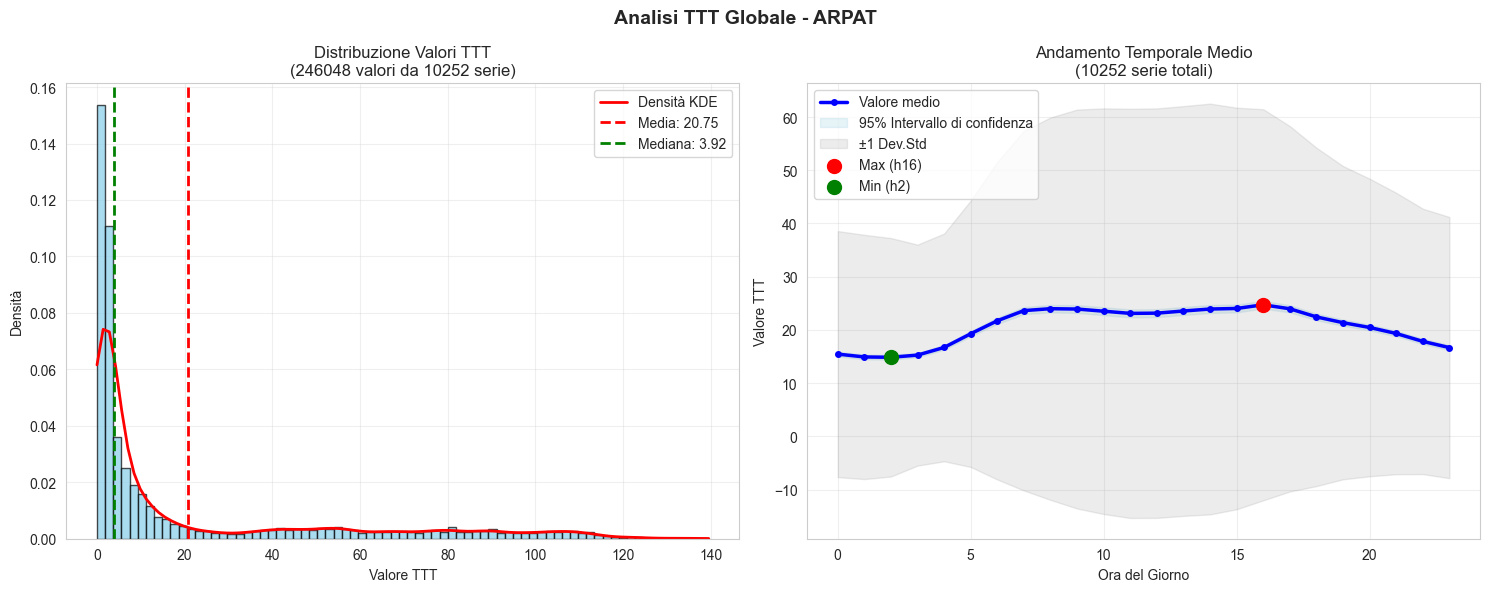

STATISTICHE GLOBALI:
  • Numero serie totali: 10252
  • Numero metriche: 5
  • Valori TTT totali: 246048
  • Media: 20.75, Mediana: 3.92, Std: 31.63
  • Min: 0.00, Max: 139.50
  • Picco a h16 (24.73), Minimo a h2 (14.86)
  • Escursione giornaliera: 9.87

=== ANALISI GRAFICI TTT GLOBALE - METRO ===



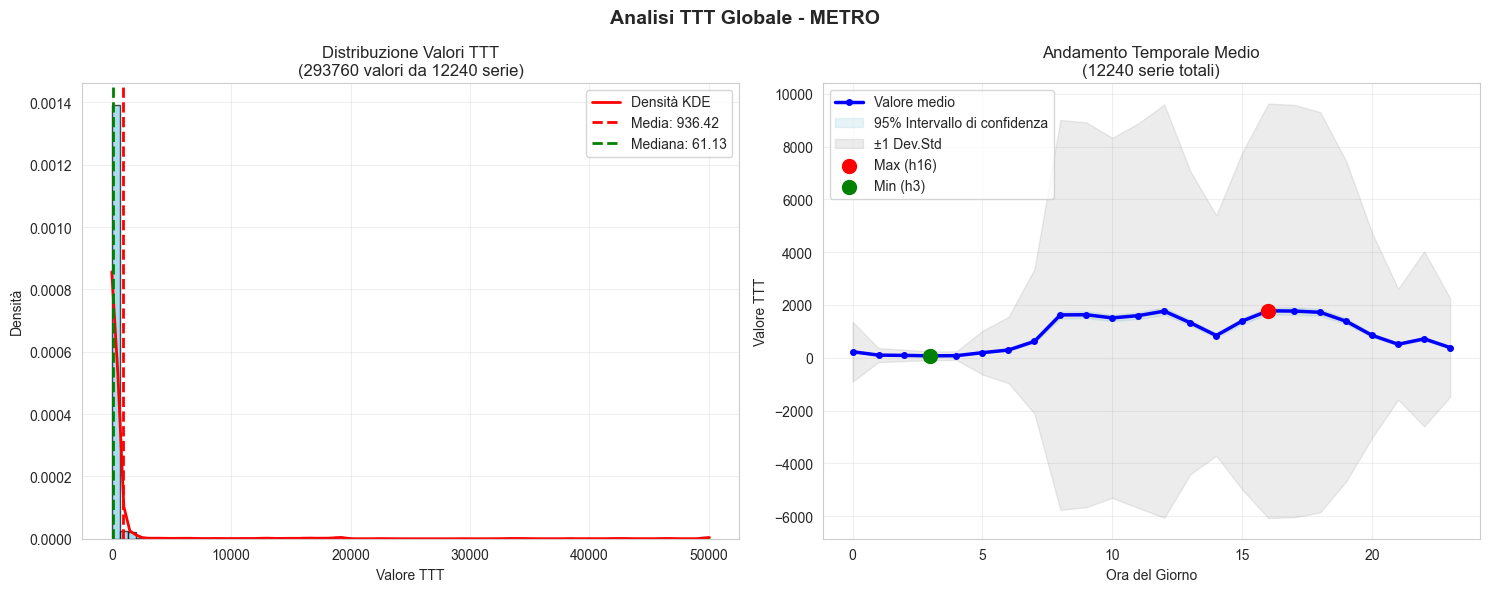

STATISTICHE GLOBALI:
  • Numero serie totali: 12240
  • Numero metriche: 6
  • Valori TTT totali: 293760
  • Media: 936.42, Mediana: 61.13, Std: 5143.32
  • Min: -1.00, Max: 50041.88
  • Picco a h16 (1778.21), Minimo a h3 (73.72)
  • Escursione giornaliera: 1704.49

=== ANALISI GRAFICI TTT GLOBALE - TOS ===



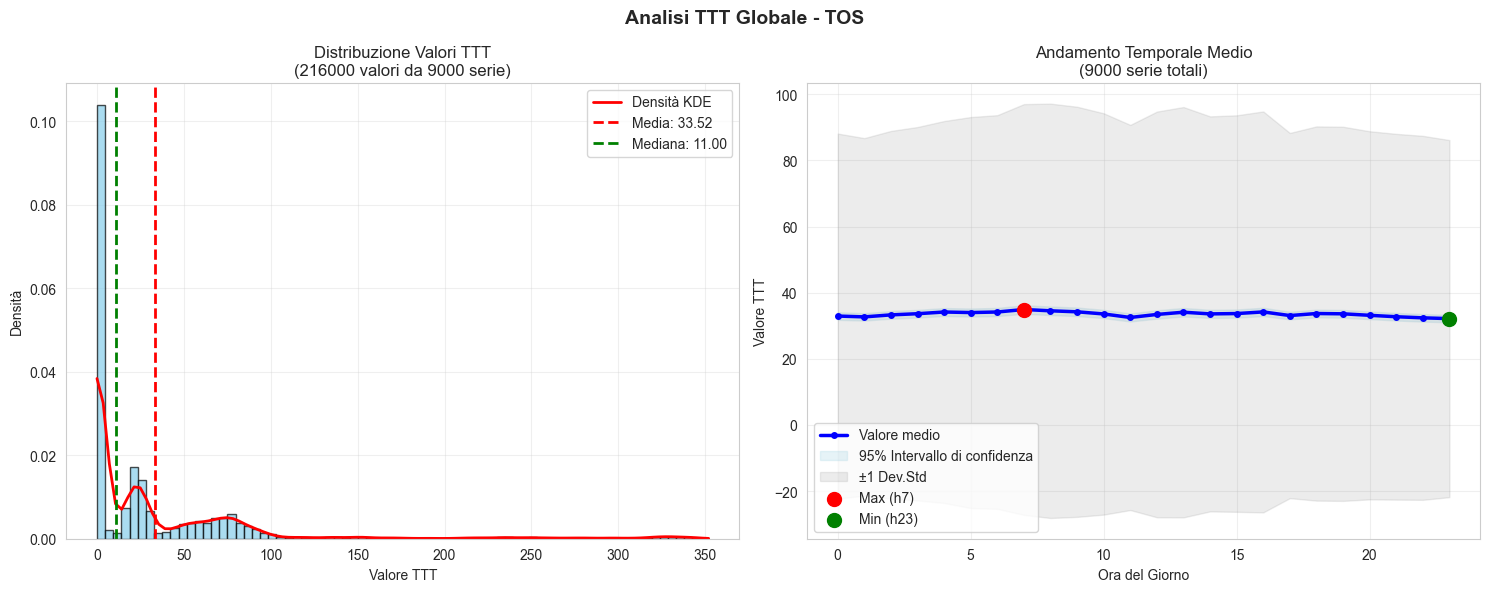

STATISTICHE GLOBALI:
  • Numero serie totali: 9000
  • Numero metriche: 6
  • Valori TTT totali: 216000
  • Media: 33.52, Mediana: 11.00, Std: 58.21
  • Min: 0.00, Max: 352.00
  • Picco a h7 (34.92), Minimo a h23 (32.17)
  • Escursione giornaliera: 2.75



In [18]:
def plot_ttt_analysis_global(df, nome_dataset="Dataset"):
    """
    Crea grafici della distribuzione TTT e andamento medio con intervallo di confidenza
    per l'intero dataset (senza distinzione tra metriche)
    
    Parameters:
    - df: DataFrame con colonne 'metric' e 'TTT'
    - nome_dataset: nome del dataset per i titoli
    """
    
    print(f"=== ANALISI GRAFICI TTT GLOBALE - {nome_dataset} ===\n")
    
    if len(df) == 0:
        print("Nessun dato disponibile nel dataset")
        return
    
    # Prepara i dati usando TUTTE le serie del dataset
    all_ttt_values = np.concatenate(df['TTT'].values)
    series_matrix = np.vstack(df['TTT'].values)
    hourly_mean = series_matrix.mean(axis=0)
    hourly_std = series_matrix.std(axis=0)
    hours = np.arange(len(hourly_mean))
    
    # Calcola intervallo di confidenza 95%
    n_series = len(df)
    sem = hourly_std / np.sqrt(n_series)
    ci_95 = 1.96 * sem
    
    # Crea figura con due subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Analisi TTT Globale - {nome_dataset}', 
                 fontsize=14, fontweight='bold')
    
    # --- GRAFICO 1: Distribuzione valori TTT ---
    ax1.hist(all_ttt_values, bins=75, alpha=0.7, color='skyblue', 
            edgecolor='black', density=True)
    
    # Aggiungi curva di densità con gestione errore
    if len(all_ttt_values) > 1:
        try:
            # Controlla se la varianza è troppo piccola
            if np.std(all_ttt_values) < 1e-6:
                print(" Varianza troppo piccola per KDE - uso solo istogramma")
            else:
                # Aggiungi un piccolo rumore per evitare singolarità
                noisy_data = all_ttt_values + np.random.normal(0, np.std(all_ttt_values)/100, len(all_ttt_values))
                kde = gaussian_kde(noisy_data)
                x_range = np.linspace(all_ttt_values.min(), all_ttt_values.max(), 100)
                ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densità KDE')
        except Exception as e:
            print(f"  Impossibile calcolare KDE: {e}")
    
    # Statistiche principali
    mean_val = np.mean(all_ttt_values)
    median_val = np.median(all_ttt_values)
    
    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Media: {mean_val:.2f}')
    ax1.axvline(median_val, color='green', linestyle='--', linewidth=2, 
               label=f'Mediana: {median_val:.2f}')
    
    ax1.set_title(f'Distribuzione Valori TTT\n({len(all_ttt_values)} valori da {n_series} serie)')
    ax1.set_xlabel('Valore TTT')
    ax1.set_ylabel('Densità')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- GRAFICO 2: Andamento temporale medio con IC ---
    # Linea media
    ax2.plot(hours, hourly_mean, color='blue', linewidth=2.5, 
            label='Valore medio', marker='o', markersize=4)
    
    # Intervallo di confidenza 95%
    ax2.fill_between(hours,
                    hourly_mean - ci_95,
                    hourly_mean + ci_95,
                    alpha=0.3, color='lightblue', 
                    label='95% Intervallo di confidenza')
    
    # Deviazione standard (opzionale, più leggera)
    ax2.fill_between(hours, 
                    hourly_mean - hourly_std, 
                    hourly_mean + hourly_std, 
                    alpha=0.15, color='gray', 
                    label='±1 Dev.Std')
    
    # Identifica punti di interesse
    max_hour = np.argmax(hourly_mean)
    min_hour = np.argmin(hourly_mean)
    
    ax2.scatter([max_hour], [hourly_mean[max_hour]], 
               color='red', s=100, zorder=5, label=f'Max (h{max_hour})')
    ax2.scatter([min_hour], [hourly_mean[min_hour]], 
               color='green', s=100, zorder=5, label=f'Min (h{min_hour})')
    
    ax2.set_title(f'Andamento Temporale Medio\n({n_series} serie totali)')
    ax2.set_xlabel('Ora del Giorno')
    ax2.set_ylabel('Valore TTT')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche rapide
    print(f"STATISTICHE GLOBALI:")
    print(f"  • Numero serie totali: {n_series}")
    print(f"  • Numero metriche: {df['metric'].nunique()}")
    print(f"  • Valori TTT totali: {len(all_ttt_values)}")
    print(f"  • Media: {mean_val:.2f}, Mediana: {median_val:.2f}, Std: {np.std(all_ttt_values):.2f}")
    print(f"  • Min: {np.min(all_ttt_values):.2f}, Max: {np.max(all_ttt_values):.2f}")
    print(f"  • Picco a h{max_hour} ({hourly_mean[max_hour]:.2f}), Minimo a h{min_hour} ({hourly_mean[min_hour]:.2f})")
    print(f"  • Escursione giornaliera: {hourly_mean[max_hour] - hourly_mean[min_hour]:.2f}\n")


for i, dataset in enumerate(cleaned_df):
    plot_ttt_analysis_global(dataset, nome_dataset=df_names[i])

In [ ]:
# Report riassuntivo finale 
print("=== REPORT RIASSUNTIVO FINALE ===")

print("📋 SINTESI COMPLETA ANALISI TTT")

for i, df in enumerate(cleaned_df):
    print(f"\n DATASET {df_names[i]}:")
    print("-" * 40)
    
    if len(df) > 0:
        # Calcola andamento temporale per le statistiche
        series_matrix = np.vstack(df['TTT'].values)
        hourly_mean = series_matrix.mean(axis=0)
        max_hour = np.argmax(hourly_mean)
        min_hour = np.argmin(hourly_mean)
        
        # Statistiche generali
        global_mean = df['TTT_mean'].mean()
        global_std = df['TTT_std'].mean()
        
        print(f"• Serie totali: {len(df)}")
        print(f"• Metriche: {', '.join(df['metric'].unique())}")
        print(f"• Valore medio TTT: {global_mean:.2f}")
        print(f"• Variabilità media: {global_std:.2f}")
        print(f"• Picco massimo: h{max_hour} ({hourly_mean[max_hour]:.1f})")
        print(f"• Minimo: h{min_hour} ({hourly_mean[min_hour]:.1f})")
        print(f"• Escursione giornaliera: {hourly_mean[max_hour] - hourly_mean[min_hour]:.1f}")
        
        # Top metriche per valore medio
        print(f"\n• Valori medi per metrica:")
        metric_means = df.groupby('metric')['TTT_mean'].mean().sort_values(ascending=False)
        for metrica, mean_val in metric_means.items():
            count = len(df[df['metric'] == metrica])
            print(f"  {metrica}: {mean_val:.2f} ({count} serie)")
    
    print("-" * 40)

=== REPORT RIASSUNTIVO FINALE ===
📋 SINTESI COMPLETA ANALISI TTT

 DATASET ARPAT:
----------------------------------------
• Serie totali: 5126
• Metriche: NO2, Benzene, O3, SO2, CO
• Valore medio TTT: 20.75
• Variabilità media: 5.42
• Picco massimo: h16 (24.7)
• Minimo: h2 (14.9)
• Escursione giornaliera: 9.9

• Valori medi per metrica:
  O3: 83.26 (854 serie)
  NO2: 14.44 (2248 serie)
  SO2: 2.66 (272 serie)
  Benzene: 1.17 (1296 serie)
  CO: 1.17 (456 serie)
----------------------------------------

 DATASET METRO:
----------------------------------------
• Serie totali: 6120
• Metriche: vehicleFlow, averageSpeed, congestionLevel, anomalyLevel, avgTime, concentration
• Valore medio TTT: 936.42
• Variabilità media: 705.73
• Picco massimo: h16 (1778.2)
• Minimo: h3 (73.7)
• Escursione giornaliera: 1704.5

• Valori medi per metrica:
  congestionLevel: 3664.28 (1020 serie)
  avgTime: 1382.86 (1020 serie)
  vehicleFlow: 313.40 (1020 serie)
  concentration: 112.50 (1020 serie)
  anomalyLe